In [331]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
%matplotlib inline

In [332]:
#From here: https://www.kaggle.com/robertoruiz/sberbank-russian-housing-market/dealing-with-multicollinearity/notebook
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

In [333]:
train = pd.read_csv("train_latlon.csv", parse_dates=['timestamp'],index_col='id') # index_col='id' if remove bad address, remove id
test = pd.read_csv("test_latlon.csv", parse_dates=['timestamp'],index_col='id')
df_macro = pd.read_csv("macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macro_cols)

train.head()

,Unnamed: 0,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,lat,lon
id,,,,,,,,,,,,,,,,,,,,,
1,0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,0,13,22,1,0,52,4,5850000,55.891007,37.604844
2,1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,0,15,29,1,10,66,14,6000000,55.676999,37.673135
3,2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,0,11,27,0,4,67,10,5700000,55.702946,37.741159
4,3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,1,4,4,0,0,26,3,13100000,55.843870,37.348920
5,4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,17,135,236,2,91,195,14,16331452,55.763482,37.657421


In [334]:
#Fix the bad address
fx = pd.read_excel('BAD_ADDRESS_FIX.xlsx').drop_duplicates('id').set_index('id')
train.update(fx)
test.update(fx)
print('Fix in train: ', train.index.intersection(fx.index).shape[0])
print('Fix in test : ', test.index.intersection(fx.index).shape[0])

('Fix in train: ', 550)
('Fix in test : ', 149)


1.0 44.0
1 41


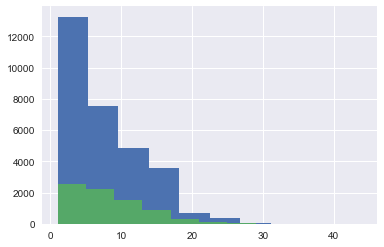

In [335]:
#Clean Jules

# Build Year
train.loc[30153,'build_year']=2015
train.loc[30278,'build_year']=np.NaN
train.loc[13995,'build_year']=2014
train.loc[26335,'build_year']=1961
train.loc[14161,'build_year']=1960
train.loc[10092,'build_year']=2009
train.loc[15223,'build_year']=1965

train.loc[train['build_year'].isin([0,1,3]),'build_year'] = np.NaN

test.loc[33469,'build_year']=2015
test.loc[test['build_year'].isin([0,1,2]),'build_year'] = np.NaN

# Max_floor
train.loc[20725,'max_floor']=9
train.loc[21737,'max_floor']=17 #Average of location (all between 14 and 25)
train.loc[21855,'max_floor']=25 #All at this location have 25
train.loc[25943,'max_floor']= np.NaN

train.loc[train['max_floor']==0,'max_floor'] = np.NaN
train.loc[train['max_floor']<train['floor'],'max_floor'] = np.NaN

test.loc[test['max_floor']==0,'max_floor'] = np.NaN
test.loc[test['max_floor']<test['floor'],'max_floor'] = np.NaN

# Floor
train.loc[train['floor']==0,'floor'] = np.NaN
train.loc[23587,'floor'] = np.NaN

train['floor'].hist()
test['floor'].hist()
print np.min(train['floor']),np.max(train['floor'])
print np.min(test['floor']),np.max(test['floor'])

# Full and life sq (Run only once!)

train.loc[[1030,27796,3599,22788,129,18344,23718,1310],['full_sq','life_sq']] = train.loc[[1030,27796,3599,22788,129,18344,23718,1310],['full_sq','life_sq']] /10.0

train.loc[[2012,1189,11335,22415,24299,26267,26366,1825],'full_sq'] = train.loc[[2012,1189,11335,22415,24299,26267,26366,1825],'life_sq']
train.loc[6115,'full_sq'] = np.NaN

train.loc[((train['full_sq']==1) & (train['life_sq']==1) & (train['floor']==1)) | ((train['full_sq']==0) & (train['life_sq']==0) & (train['floor']==0)),['full_sq','life_sq','floor','max_floor','num_room','kitch_sq','state']] = np.NaN
train.loc[((train['full_sq']==0) | (train['full_sq']==1)) & train['life_sq']>5, 'full_sq'] = train.loc[((train['full_sq']==0) | (train['full_sq']==1)) & train['life_sq']>5, 'life_sq']

train.loc[(train['life_sq']>1) & (train['full_sq']>100*train['life_sq']),'full_sq'] = train.loc[(train['life_sq']>1) & (train['full_sq']>100*train['life_sq']),'full_sq']/100.0
train.loc[(train['life_sq']>1) & (train['full_sq']>10*train['life_sq']),'full_sq'] = train.loc[(train['life_sq']>1) & (train['full_sq']>10*train['life_sq']),'full_sq']/10.0

train.loc[(train['life_sq']>1) & (train['full_sq']/train['life_sq']<0.05),'life_sq'] = train.loc[(train['life_sq']>1) & (train['full_sq']/train['life_sq']<0.5),'life_sq']/100.0
train.loc[(train['life_sq']>1) & (train['full_sq']/train['life_sq']<0.5),'life_sq'] = train.loc[(train['life_sq']>1) & (train['full_sq']/train['life_sq']<0.5),'life_sq']/10.0

train.loc[(train['full_sq']==0) | (train['full_sq']==1),'full_sq'] = np.NaN
train.loc[(train['life_sq']==0) | (train['life_sq']==1),'life_sq'] = np.NaN



test.loc[[30938,35857],'full_sq'] = test.loc[[30938,35857],'life_sq']
test.loc[36824, ['full_sq','life_sq']] = np.NaN
test.loc[[32501,33278],'life_sq'] = np.NaN

test.loc[(test['life_sq']>1) & (test['full_sq']/test['life_sq']<0.5),'life_sq'] = test.loc[(test['life_sq']>1) & (test['full_sq']/test['life_sq']<0.5),'life_sq']/10.0

test.loc[(test['life_sq']==0 ) | (test['life_sq']==1 ),'life_sq'] = np.NaN

# Kitchen (Only run once!)

train.loc[[10371,21418,13120,28737],'build_year'] = train.loc[[10371,21418,13120,28737],'kitch_sq'].copy()
train.loc[[10371,21418,13120,28737],'kitch_sq'] = np.NaN

train.loc[(train['kitch_sq']==0) | (train['kitch_sq']==1),'kitch_sq'] = np.NaN
train.loc[(train['kitch_sq'] >= train['full_sq']) | (train['kitch_sq']>= train['life_sq']),'kitch_sq'] = np.NaN

test.loc[[31381,36811],'kitch_sq'] = np.NaN
test.loc[test['kitch_sq']==test['full_sq'],'kitch_sq'] = np.NaN
test.loc[[37733,37503],'kitch_sq'] = np.NaN

test.loc[[32505,34333,36970],'kitch_sq'] = test.loc[[32505,34333,36970],'kitch_sq']/10.0
test.loc[[31014,32266],['kitch_sq','life_sq']] = test.loc[[31014,32266],['life_sq','kitch_sq']]
test.loc[(test['kitch_sq'] >= test['full_sq']) | (test['kitch_sq']>= test['life_sq']),'kitch_sq'] = np.NaN
test.loc[(test['kitch_sq']==0) | (test['kitch_sq']==1),'kitch_sq'] = np.NaN

# Room
train.loc[train['num_room']==0, 'num_room'] = np.NaN
train.loc[train['num_room'] >= 10, 'num_room'] = np.NaN
train.loc[[19393,25350,26002,17431,25284,12201,14592,11020,25654],'num_room'] = np.NaN

test.loc[31301, 'num_room'] = 3 #kitch_sq
test.loc[[33648,37787,31903],'num_room'] = np.NaN

# State
train.loc[10092,'state'] = 3

In [336]:
#clean data
#bad_index = train[train.life_sq > train.full_sq].index
#train.ix[bad_index, "life_sq"] = np.NaN
#equal_index = [601,1896,2791]
#test.ix[equal_index, "life_sq"] = test.ix[equal_index, "full_sq"]
#bad_index = test[test.life_sq > test.full_sq].index
#test.ix[bad_index, "life_sq"] = np.NaN
#bad_index = train[train.life_sq < 5].index
#train.ix[bad_index, "life_sq"] = np.NaN
#bad_index = test[test.life_sq < 5].index
#test.ix[bad_index, "life_sq"] = np.NaN
#bad_index = train[train.full_sq < 5].index
#train.ix[bad_index, "full_sq"] = np.NaN
#bad_index = test[test.full_sq < 5].index
#test.ix[bad_index, "full_sq"] = np.NaN
#kitch_is_build_year = [13117]
#train.ix[kitch_is_build_year, "build_year"] = train.ix[kitch_is_build_year, "kitch_sq"]
#bad_index = train[train.kitch_sq >= train.life_sq].index
#train.ix[bad_index, "kitch_sq"] = np.NaN
#bad_index = test[test.kitch_sq >= test.life_sq].index
#test.ix[bad_index, "kitch_sq"] = np.NaN
#bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
#train.ix[bad_index, "kitch_sq"] = np.NaN
#bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
#test.ix[bad_index, "kitch_sq"] = np.NaN
#bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
#train.ix[bad_index, "full_sq"] = np.NaN
#bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
#test.ix[bad_index, "full_sq"] = np.NaN
#bad_index = train[train.life_sq > 300].index
#train.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
#bad_index = test[test.life_sq > 200].index
#test.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
#train.product_type.value_counts(normalize= True)
#test.product_type.value_counts(normalize= True)
#bad_index = train[train.build_year < 1500].index
#train.ix[bad_index, "build_year"] = np.NaN
#bad_index = test[test.build_year < 1500].index
#test.ix[bad_index, "build_year"] = np.NaN
#bad_index = train[train.num_room == 0].index 
#train.ix[bad_index, "num_room"] = np.NaN
#bad_index = test[test.num_room == 0].index 
#test.ix[bad_index, "num_room"] = np.NaN
#bad_index = [10076, 11621, 17764, 19390, 24007, 26713, 29172]
#train.ix[bad_index, "num_room"] = np.NaN
#bad_index = [3174, 7313]
#test.ix[bad_index, "num_room"] = np.NaN
#bad_index = train[(train.floor == 0).values * (train.max_floor == 0).values].index
#train.ix[bad_index, ["max_floor", "floor"]] = np.NaN
#bad_index = train[train.floor == 0].index
#train.ix[bad_index, "floor"] = np.NaN
#bad_index = train[train.max_floor == 0].index
#train.ix[bad_index, "max_floor"] = np.NaN
#bad_index = test[test.max_floor == 0].index
#test.ix[bad_index, "max_floor"] = np.NaN
#bad_index = train[train.floor > train.max_floor].index
#train.ix[bad_index, "max_floor"] = np.NaN
#bad_index = test[test.floor > test.max_floor].index
#test.ix[bad_index, "max_floor"] = np.NaN
#train.floor.describe(percentiles= [0.9999])
#bad_index = [23584]
#train.ix[bad_index, "floor"] = np.NaN
#train.material.value_counts()
#test.material.value_counts()
#train.state.value_counts()
#bad_index = train[train.state == 33].index
#train.ix[bad_index, "state"] = np.NaN
#test.state.value_counts()

# brings error down a lot by removing extreme price per sqm
#train.loc[train.full_sq == 0, 'full_sq'] = 50
#train = train[train.price_doc/train.full_sq <= 600000]
#train = train[train.price_doc/train.full_sq >= 10000]

# Add month-year
#month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
#month_year_cnt_map = month_year.value_counts().to_dict()
#train['month_year_cnt'] = month_year.map(month_year_cnt_map)

#month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
#month_year_cnt_map = month_year.value_counts().to_dict()
#test['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
#week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
#week_year_cnt_map = week_year.value_counts().to_dict()
#train['week_year_cnt'] = week_year.map(week_year_cnt_map)

#week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
#week_year_cnt_map = week_year.value_counts().to_dict()
#test['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
#train['month'] = train.timestamp.dt.month
#train['dow'] = train.timestamp.dt.dayofweek

#test['month'] = test.timestamp.dt.month
#test['dow'] = test.timestamp.dt.dayofweek

# Other feature engineering
#train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
#train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

#test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
#test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

#train.apartment_name=train.sub_area + train['metro_km_avto'].astype(str)
#test.apartment_name=test.sub_area + train['metro_km_avto'].astype(str)

#train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
#test['room_size'] = test['life_sq'] / test['num_room'].astype(float)

#y_train = train["price_doc"]
#x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
#x_test = test.drop(["id", "timestamp"], axis=1)

for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True)  

In [337]:
#Cleaned _ Jules
#df_train.loc[30153,'build_year']=2015
#df_train.loc[30278,'build_year']=np.NaN
#df_train.loc[13995,'build_year']=2014
#df_train.loc[26335,'build_year']=1961
#df_train.loc[14161,'build_year']=1960
#df_train.loc[df_train['build_year'].isin([0,1,3]),'build_year'] = np.NaN
#df_train.loc[10092,'build_year']=2009
#df_train.loc[15223,'build_year']=1965
#df_train.loc[20725,'max_floor']=9
#df_train.loc[21737,'max_floor']=17
#df_train.loc[21855,'max_floor']=25
#df_train.loc[df_train['max_floor']==0,'max_floor'] = np.NaN
#df_train.loc[df_train['max_floor']<df_train['floor'],'max_floor'] = np.NaN
#df_train['max_floor'].hist()
#df_train.loc[df_train['floor']==0,'floor'] = np.NaN
#df_train.loc[((df_train['full_sq']==1) & (df_train['life_sq']==1) & (df_train['floor']==1)) | ((df_train['full_sq']==0) & (df_train['life_sq']==0) & (df_train['floor']==0)),['full_sq','life_sq','floor','max_floor','num_room','kitch_sq','state']] = np.NaN

In [338]:
#def fill_state(df):
    #df_state = df[~pd.isnull(df.state) & ~pd.isnull(df.build_year)]
    #df_state_grouped = df_state.groupby('build_year')
    #maxs={}
    #for name,group in df_state_grouped:
        #grp = group.groupby('state').count()['full_sq']
        #maxs[name] = np.argmax(grp)
    #df_state_null = df[pd.isnull(df.state)]
    #df_state_null.build_year = df_state_null.build_year.map(maxs)
    #df_state_notnull = df[~pd.isnull(df.state)]
    #df = pd.concat([df_state_notnull,df_state_null])
    #df = df.drop('latlon')
    #return df

#train = fill_state(train)
#test = fill_state(test)

In [339]:
#fill missing values
def fill_life_sq(df):
    df_life_notnull = df[~pd.isnull(df.life_sq) & ~pd.isnull(df.full_sq)]
    df_life_notnull['ratio'] = df_life_notnull.life_sq/df_life_notnull.full_sq
    mean = df_life_notnull.ratio.mean()
    df_life_null = df[pd.isnull(df.life_sq)]
    df_life_null.life_sq = df_life_null.full_sq * mean
    df_life_notnull = df[~pd.isnull(df.life_sq)]
    df = pd.concat([df_life_notnull,df_life_null])
    return df

def fill_maxfloor(df):
    df['latlon'] = [(x,y) for x,y in zip(df.lat,df.lon)]
    df_maxfloor = df[~pd.isnull(df.lat) & ~pd.isnull(df.lon) & ~pd.isnull(df.max_floor)]
    df_maxfloor_grouped = df_maxfloor.groupby(['latlon'])
    maxf={}
    for name,group in df_maxfloor_grouped:
        grp = group.groupby('max_floor').count()['full_sq'] #replace by full_sq , previously price_doc
        maxf[(round(name[0],3),round(name[1],3))] = np.argmax(grp)
    df_maxf_null = df[pd.isnull(df.max_floor)]
    df_maxf_null.max_floor = df_maxf_null.latlon.map(maxf)
    df_maxf_notnull = df[~pd.isnull(df.max_floor)]
    df = pd.concat([df_maxf_notnull,df_maxf_null])
    #df = df.drop('latlon')
    return df

def fill_buildyear(df,method='loc'):
    if method =='material':
        df_year = df[~pd.isnull(df.material) & ~pd.isnull(df.build_year)]
        df_year_grouped = df_year.groupby('material')
        maxy={}
        for name,group in df_year_grouped:
            grp = group.groupby('build_year').count()['full_sq'] #replace by full_sq
            maxy[name] = np.argmax(grp)
        df_year_null = df[pd.isnull(df.build_year)]
        df_year_null.build_year = df_year_null.material.map(maxy)
        df_year_notnull = df[~pd.isnull(df.build_year)]
        df = pd.concat([df_year_notnull,df_year_null])
        #df = df.drop('latlon')
    elif method =='loc':
        df['latlon'] = [(x,y) for x,y in zip(df.lat,df.lon)]
        df_year = df[~pd.isnull(df.lat) & ~pd.isnull(df.lon) & ~pd.isnull(df.build_year)]
        df_year_grouped = df_year.groupby(['latlon'])
        maxy={}
        for name,group in df_year_grouped:
            grp = group.groupby('build_year').count()['full_sq']  #replace by full_sq
            maxy[(round(name[0],3),round(name[1],3))] = np.argmax(grp)
        df_year_null = df[pd.isnull(df.build_year)]
        df_year_null.build_year = df_year_null.latlon.map(maxy)
        df_year_notnull = df[~pd.isnull(df.build_year)]
        df = pd.concat([df_year_null,df_year_notnull])
    #df = df.drop('latlon')   
    
    return df


def fill_state(df):
    df_year = df[~pd.isnull(df.state) & ~pd.isnull(df.build_year)]
    df_year_grouped = df_year.groupby('build_year')
    maxy={}
    for name,group in df_year_grouped:
        grp = group.groupby('state').count()['full_sq']
        maxy[name] = np.argmax(grp)
    df_year_null = df[pd.isnull(df.state)]
    df_year_null.build_year = df_year_null.build_year.map(maxy)
    df_year_notnull = df[~pd.isnull(df.state)]
    df = pd.concat([df_year_notnull,df_year_null])
    #df = df.drop('latlon')
    return df

In [340]:
#train['state'].fillna(train['state'].mean(),inplace=True)
#test['state'].fillna(test['state'].mean(),inplace=True)

#train['state'].fillna(train['maxfloor'].value_counts().index[0],inplace=True)
#test['state'].fillna(test['state'].value_counts().index[0],inplace=True)

#train['life_sq'].fillna(train['life_sq'].mean(),inplace=True)
#test['life_sq'].fillna(test['life_sq'].mean(),inplace=True)

#train['build_year'].fillna(train['build_year'].mean(),inplace=True)
#test['build_year'].fillna(test['build_year'].mean(),inplace=True)

train['max_floor'].fillna(train['max_floor'].median(),inplace=True)
test['max_floor'].fillna(test['max_floor'].median(),inplace=True)

train['state'].fillna(train['state'].value_counts().index[0],inplace=True)
test['state'].fillna(test['state'].value_counts().index[0],inplace=True)

In [341]:
#train = fill_life_sq(train)
#test = fill_life_sq(test)

#train = fill_maxfloor(train)
#test = fill_maxfloor(test)

#train = fill_buildyear(train)
#test = fill_buildyear(test)

#train = fill_state(train)
#test = fill_state(test)

In [342]:
#train.drop(['lat','lon','latlon'],axis=1,inplace=True)
#test.drop(['lat','lon','latlon'],axis=1,inplace=True)

In [343]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

#ylog will be log(1+y), as suggested by https://github.com/dmlc/xgboost/issues/446#issuecomment-135555130
ylog_train_all = np.log1p(train['price_doc'].values)
id_test = test['id']

train.drop(['id', 'price_doc'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

#Build df_all = (df_train+df_test).join(df_macro)
num_train = len(train)
df_all = pd.concat([train, test])
df_all = pd.merge_ordered(df_all, df_macro, on='timestamp', how='left')
print(df_all.shape)

# Add month-year
#month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
#month_year_cnt_map = month_year.value_counts().to_dict()
#df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
#week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
#week_year_cnt_map = week_year.value_counts().to_dict()
#df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
#df_all['month'] = df_all.timestamp.dt.month
#df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
#df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
#df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

#Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp'], axis=1, inplace=True)

(38133, 306)


In [344]:
#Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

In [345]:
# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

# Create a validation set, with last 20% of data
num_val = int(num_train * 0.2)

X_train_all = X_all[:num_train]
X_train = X_all[:num_train-num_val]
X_val = X_all[num_train-num_val:num_train]
ylog_train = ylog_train_all[:-num_val]
ylog_val = ylog_train_all[-num_val:]

X_test = X_all[num_train:]

df_columns = df_values.columns

print('X_train_all shape is', X_train_all.shape)
print('X_train shape is', X_train.shape)
print('y_train shape is', ylog_train.shape)
print('X_val shape is', X_val.shape)
print('y_val shape is', ylog_val.shape)
print('X_test shape is', X_test.shape)

(38133, 305)
('X_train_all shape is', (30471, 305))
('X_train shape is', (24377, 305))
('y_train shape is', (24377,))
('X_val shape is', (6094, 305))
('y_val shape is', (6094,))
('X_test shape is', (7662, 305))


In [346]:
X_train_all[np.isnan(X_train_all)]=-999999
ylog_train_all[np.isnan(ylog_train_all)]=-999999
X_train[np.isnan(X_train)]=-999999
ylog_train[np.isnan(ylog_train)]=-999999
X_val[np.isnan(X_val)]=-999999
ylog_val[np.isnan(ylog_val)]=-999999
X_test[np.isnan(X_test)]=-999999

In [347]:
dtrain_all = xgb.DMatrix(X_train_all, ylog_train_all,missing=-999999)
dtrain = xgb.DMatrix(X_train, ylog_train,missing=-999999)
dval = xgb.DMatrix(X_val, ylog_val,missing=-999999)
dtest = xgb.DMatrix(X_test,missing=-999999)

In [348]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

Will train until val error hasn't decreased in 20 rounds.
[0]	val-rmse:14.476534
[1]	val-rmse:13.759713
[2]	val-rmse:13.077559
[3]	val-rmse:12.430729
[4]	val-rmse:11.816127
[5]	val-rmse:11.232455
[6]	val-rmse:10.677903
[7]	val-rmse:10.149446
[8]	val-rmse:9.649486
[9]	val-rmse:9.174491
[10]	val-rmse:8.722984
[11]	val-rmse:8.292825
[12]	val-rmse:7.885278
[13]	val-rmse:7.496508
[14]	val-rmse:7.128731
[15]	val-rmse:6.778295
[16]	val-rmse:6.445522
[17]	val-rmse:6.129387
[18]	val-rmse:5.829832
[19]	val-rmse:5.545237
[20]	val-rmse:5.274439
[21]	val-rmse:5.018125
[22]	val-rmse:4.773926
[23]	val-rmse:4.541824
[24]	val-rmse:4.321252
[25]	val-rmse:4.112243
[26]	val-rmse:3.913694
[27]	val-rmse:3.725366
[28]	val-rmse:3.546070
[29]	val-rmse:3.376483
[30]	val-rmse:3.215214
[31]	val-rmse:3.062080
[32]	val-rmse:2.916537
[33]	val-rmse:2.778295
[34]	val-rmse:2.647294
[35]	val-rmse:2.522891
[36]	val-rmse:2.405396
[37]	val-rmse:2.293604
[38]	val-rmse:2.187714
[39]	val-rmse:2.086858
[40]	val-rmse:1.991738
[

In [349]:
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

In [271]:
ylog_pred = model.predict(dtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

In [273]:
df_sub.to_csv('fillna_state_freq_0.416984.csv', index=False)

In [ ]:
['max_floor','life_sq','build_year']